<a href="https://colab.research.google.com/github/tony-wade/chart-digitizer/blob/main/Sampling_from_curves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # pic output
from sklearn.cluster import MiniBatchKMeans

In [ ]:
def axis_position(bool_array):
  '''Get axis' length through longest line'''
  max_length = 0
  current_length = 0
  start_idx = 0
  end_idx = 0
  for idx, value in enumerate(bool_array):
    if value:
      current_length += 1
    elif current_length > max_length:
      end_idx = idx - 1
      start_idx = end_idx - current_length + 1
      max_length = current_length
      current_length = 0
    else:
      current_length = 0

  return start_idx, end_idx

In [ ]:
def get_line_colors(image_clean, num_colors=1):
    '''Sense curves' color code in pure background'''
    if image_clean.ndim == 2: # 灰度圖
        image_clean_rgb = cv2.cvtColor(image_clean, cv2.COLOR_GRAY2RGB)  # to RGB
    elif image_clean.ndim == 3 and image_clean.shape[2] == 3: # 3 channel
        image_clean_rgb = image_clean
    else:
        print("輸入圖片格式不符合預期 (應為灰度或 3 通道)。")
        return np.array([]), np.array([]) # Return empty arrays for both colors and std_devs

    pixels = image_clean_rgb.reshape(-1, 3) # only color

    non_background_pixels_indices = ~np.all(pixels == [0, 0, 0], axis=1)
    # non_background_pixels_indices = ~np.all(pixels == [255, 255, 255], axis=1)

    filtered_pixels = pixels[non_background_pixels_indices]

    if len(filtered_pixels) == 0:
        print("沒有檢測到非背景像素，可能圖片是純背景或顏色數量設置過低。")
        return np.array([]), np.array([]) # Return empty arrays

    kmeans = MiniBatchKMeans(n_clusters=num_colors, random_state=42, n_init='auto', batch_size=512, max_iter=100)
    kmeans.fit(filtered_pixels)

    dominant_colors = np.round(kmeans.cluster_centers_).astype(int)

    # Calculate std
    std_devs = []
    for i in range(num_colors):
        cluster_pixels = filtered_pixels[kmeans.labels_ == i]
        if len(cluster_pixels) > 0:
            std_dev = np.std(cluster_pixels, axis=0)
            std_devs.append(std_dev)
        else:
            std_devs.append(np.zeros(3)) # Append zero std dev if cluster is empty

    std_devs = np.array(std_devs)

    return dominant_colors, std_devs

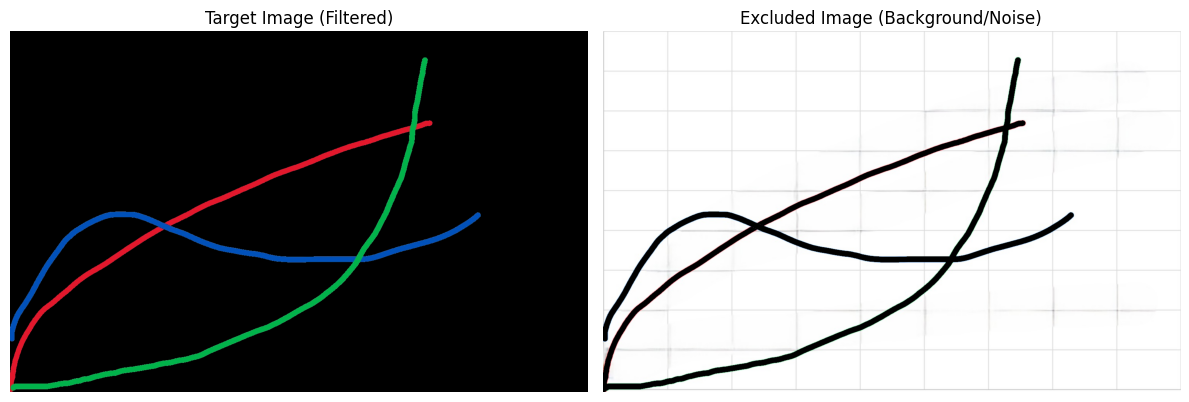

In [ ]:
def crop_the_chart(image_path, white_mask_value=255, ratio=1):
    """
    Crop and separate chart components into pure line drawings and background grid/numbers.
    Please make sure all the curves are properly picked.

    Args:
        image_path : str

        white_mask_value : int, optional (default=255)
            Pixel intensity used for masking background areas (usually white).
            This value defines the threshold for "white" when creating masks.

        ratio : float, optional (default=1)
            Standard deviation multiplier used to determine color variance threshold.

    Returns:
        Tuple containing height, width, BGR, representing curve-only, no background color image,
        also plot a pair of images for visualization.
    """
    try:
        img = cv2.imread(image_path) # BGR

        height, width, _ = img.shape  # H, W, COLER

        # Remove background
        blue_condition = img[:, :, 0] < white_mask_value
        green_condition = img[:, :, 1] < white_mask_value
        red_condition = img[:, :, 2] < white_mask_value
        white_mask = blue_condition & green_condition & red_condition

        vertical_line_pos = [val for val in range(width) if white_mask.sum(axis=0)[val] == white_mask.sum(axis=0).max()]
        horizontal_line_pos = [val for val in range(height) if white_mask.sum(axis=1)[val] == white_mask.sum(axis=1).max()]

        # Get axes
        vertical_lb, vertical_ub = axis_position(white_mask[:, vertical_line_pos[0]])       # left to right
        horizontal_lb, horizontal_ub = axis_position(white_mask[horizontal_line_pos[-1], :])    # top to bottom
        #print(f"垂直線座標: ({vertical_lb}, {vertical_ub})")
        #rint(f"水平線座標: ({horizontal_lb}, {horizontal_ub})")

        crop_img = img[vertical_lb:vertical_ub, horizontal_lb:horizontal_ub]
        b,g,r = crop_img[:,0,0], crop_img[:,0,1], crop_img[:,0,2]   # y axis

        mean_bgr = np.array([np.mean(b), np.mean(g), np.mean(r)])
        std_bgr = np.array([np.std(b), np.std(g), np.std(r)])
        lower_bound = mean_bgr - ratio * std_bgr
        upper_bound = mean_bgr + ratio * std_bgr
        conditions = (crop_img <= lower_bound) | (crop_img >= upper_bound)  # h,w,3
        target_mask = np.any(conditions, axis=2)[:, :, np.newaxis]

        crop_img = crop_img[:, :, ::-1]  # plt is RGB format
        target_img = crop_img * target_mask
        exclude_img = crop_img * ~target_mask

        # Plot
        plt.figure(figsize=(12, 6))  # total size

        plt.subplot(1, 2, 1) # 1st pic
        plt.imshow(target_img)
        plt.title('Target Image (Filtered)')
        plt.axis('off')

        plt.subplot(1, 2, 2) # 2nd pic
        plt.imshow(exclude_img)
        plt.title('Excluded Image (Background/Noise)')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        return target_img

    except FileNotFoundError:
        print(f"錯誤: 找不到圖片檔案於 {image_path}")
        return None
    except Exception as e:
        print(f"讀取圖片並處理像素時發生錯誤: {e}")
        return None

img = crop_the_chart('test2.jpg', 245, 3)

In [ ]:
def plot_and_export_data(data, sample_range, color_set, output_filename="output"):
    """
    Plots the digital data and exports it to a CSV file.

    Args:
      data (list): A list of lists, where each inner list contains the
                            digital values for a curve.
      sample_range (tuple): A tuple representing sample range (x_min, x_max).
      output_filename (str): The name of the CSV file to save the data to.
    """
    num_colors = len(data)

    x_min, x_max = sample_range
    sample_size = (x_max - x_min) // len(data[0])

    x_values = np.arange(x_min, x_max, sample_size)

    plt.figure(figsize=(10, 6))
    rgb_colors = color_set[:, ::-1] / 255.0

    for i in range(num_colors):
        plt.plot(x_values, data[i], label=f'Curve {i+1}', color=rgb_colors[i])

    plt.xlabel('Sample Range')
    plt.ylabel('Value')
    plt.title('Sampled Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Export to CSV
    df = pd.DataFrame(np.array(data).T, columns=[f'Curve_{i+1}' for i in range(num_colors)])
    df.insert(0, 'Sample_Range', x_values)
    df.to_csv(f"{output_filename}.csv", index=False)
    print(f"Data exported to {output_filename}.csv")

In [ ]:
def pad_curve_to_smooth(input_arr: np.ndarray, threshold: float) -> np.ndarray:
    '''Padding strategy for overlapped area'''
    diff_value = np.diff(input_arr)    # width-1
    rise_mask = diff_value > threshold
    fall_mask = diff_value < -threshold

    width = len(input_arr)
    interp_mask = np.full(width, False, dtype=bool)

    cache_idx = 0  # set start from origin if miss value
    rise_flag = False
    fall_flag = False if input_arr[0] != 0 else True  # No value at origin

    for idx in range(width - 1):
        # update states
        rise_flag = True if rise_mask[idx] else rise_flag
        fall_flag = True if fall_mask[idx] else fall_flag

        # pad segement
        if rise_flag and fall_flag:
            interp_mask[cache_idx+1 : idx+1] = True  # pass
            rise_flag = False
            fall_flag = False
            continue

        # soar/plunge are ignored
        elif (rise_flag and rise_mask[idx]) or (fall_flag and fall_mask[idx]):
            cache_idx = idx

    if np.any(interp_mask):
        pic_range = np.arange(width)
        xp_known = pic_range[~interp_mask]
        fp_known = input_arr[~interp_mask]
        input_arr = np.interp(pic_range, xp_known, fp_known)

    return input_arr


def digitize_curve(image, value_range, sample_range, sample_step=1, num_color=1, ratio=3, integer_val=False):
    '''
    Digitize curve data from cropped chart and output sample data in CSV file.

    Args:
        image : ndarray
            The input image (typically a cropped chart) in BGR or RGB format.

        value_range : tuple of float
            The (y_min, y_max) range of the data represented on the chart.
            This is used to map pixel coordinates to actual data values.

        sample_range : tuple of int
            The (x_min, x_max) pixel range along the x-axis to sample.

        sample_step : int, optional (default=1)
            Step size when sampling pixels along the x-axis.

        num_color : int, optional (default=1)
            Number of distinct curve colors to detect.
            Used only when the chart lines are continuous (not dotted/dashed).

        ratio : float, optional (default=3)
            Standard deviation multiplier used to differentiate curve colors

        integer_val : bool, optional (default=False)
            Set True if y-axis/output value is integer.

    Returns:
        A .csv file that contains (samples, num_coloers), also a chart will be plot for visualization.
    '''
    height, width, _ = image.shape
    y_min, y_max = value_range
    x_min, x_max = sample_range
    pic_range = [idx for idx in range(width)]
    threshold = 0.015 * height

    x_rescale_ratio = width / (x_max - x_min)
    y_rescale_ratio = height / (y_max - y_min)

    # Sense colors
    color_set, color_stds = get_line_colors(image, num_color)   # (num_color, 3)
    #print(color_set)

    sample_values = []

    for idx in range(num_color):
        pic_value = np.zeros(width)

        lb, ub = color_set[idx] - ratio * color_stds[idx], color_set[idx] + ratio * color_stds[idx]
        conditions = (image >= lb) & (image <= ub)  # broadcast
        color_match_mask = np.all(conditions, axis=2)
        y_indices, x_indices = np.where(color_match_mask)  # left to right, top to toe

        counts = np.bincount(x_indices, minlength=width)   # 0~width
        y_sum = np.bincount(x_indices, weights=y_indices, minlength=width)  # sum of y-values under each x
        non_zero_mask = counts > 0

        pic_value[non_zero_mask] = (height - (y_sum[non_zero_mask] / counts[non_zero_mask]))  # avg position as curve value
        pic_value = pad_curve_to_smooth(pic_value, threshold)
        sample_values.append(pic_value / y_rescale_ratio)  # transform to output value range

    # Interpolation for different sample size
    output_data = []
    desire_sample_range = [idx * x_rescale_ratio for idx in range(x_min, x_max, sample_step)]  # turn into width range

    for num in range(num_color):
        value = np.interp(x=desire_sample_range, xp=pic_range, fp=sample_values[num])
        value = np.round(value) if integer_val else value
        output_data.append(value)

    return output_data, color_set

Processing: test2.jpg


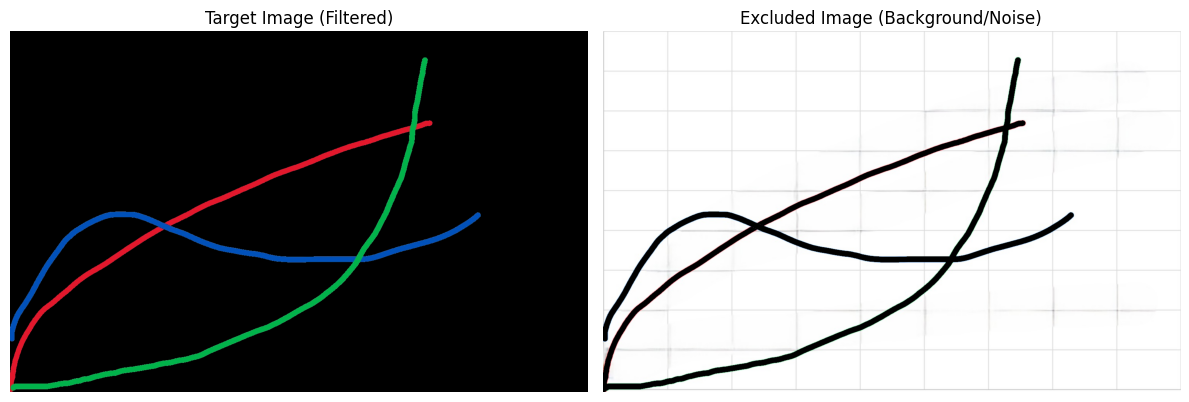

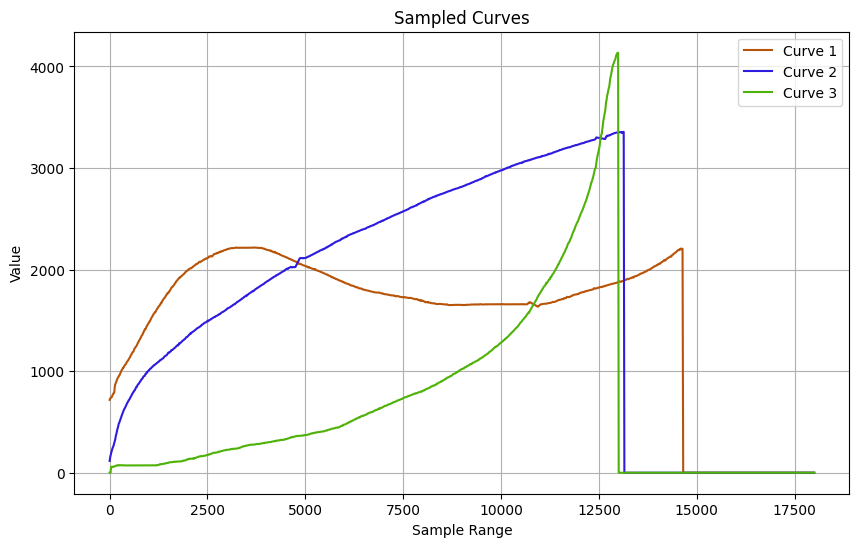

Data exported to test2.csv
Processing: test.jpg


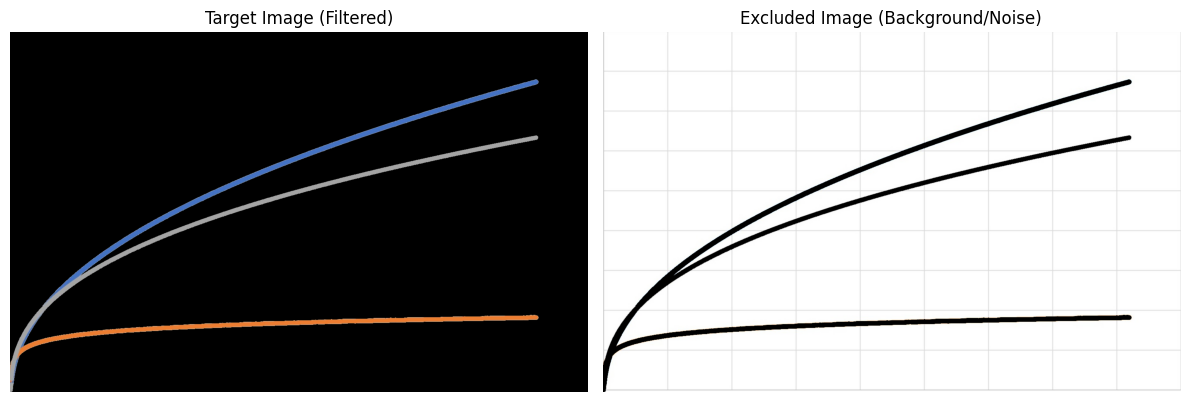

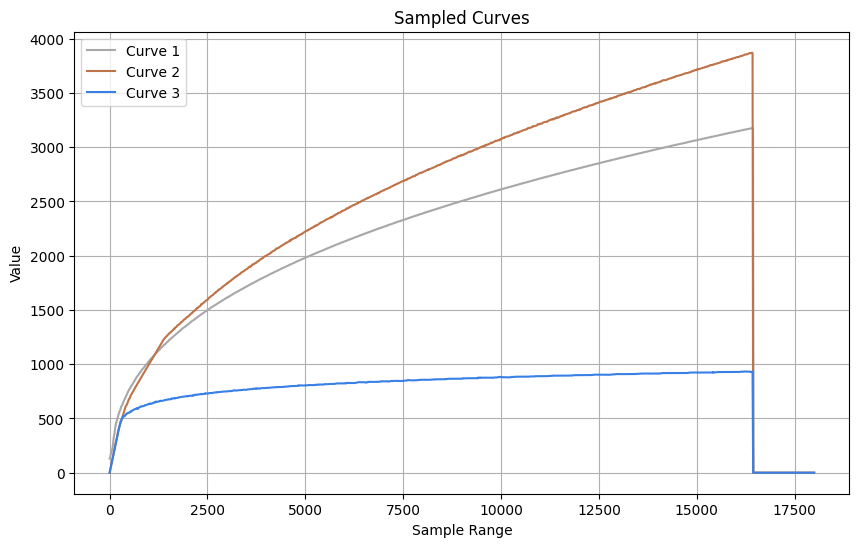

Data exported to test.csv


In [ ]:
def is_image_file(filename):
    """Check if file has a valid image extension."""
    valid_exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.webp')
    return filename.lower().endswith(valid_exts)


def sample_img_folder(folder_path, output_enable=True):
    """
    Process all images in the given folder by cropping and digitizing curves.

    Args:
        folder_path: str
        output_enable: bool (default: True)
                For curve-cropping quality check. 評估曲線篩選成果用

    IMPORTANT:
        All images share the same conditions (value_range/sample_range, num_color...).
        Grid lines and axis colors should not be too similar to the curve colors.
        Background should be as close to pure white as possible for best results.
        所有輸出條件須相同(輸出範圍, 曲線數...)，且格線和軸的顏色不可過於接近曲線，背景盡量純白。
    """
    file_list = os.listdir(folder_path)

    for filename in file_list:
        if not is_image_file(filename):
            continue  # Skip

        image_path = os.path.join(folder_path, filename)
        image_name = os.path.splitext(filename)[0]
        print(f"Processing: {filename}")

        # 請確認曲線有被正確讀出，否則須調整遮罩與格線色彩容忍度
        cropped_img = crop_the_chart(image_path=image_path,
                                  white_mask_value=245,
                                  ratio=3
                                  )


        value_range = (0, 4500)      # y-axis range
        sample_range = (0, 18000)     # x-axis range
        sample_step = 1
        num_color = 3            # = number of curves in chart

        curves, color_set = digitize_curve(image=cropped_img,
                              value_range=value_range,
                              sample_range=sample_range,
                              sample_step=sample_step,
                              num_color=num_color,
                              ratio=1.3,
                              integer_val=False
                              )
        if output_enable:
            plot_and_export_data(data=curves, sample_range=sample_range, color_set=color_set, output_filename=image_name)


sample_img_folder("./")  # 資料夾路徑